In [1]:
#!pip install transformers

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModel
import torch
import re
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\regmi\.conda\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

In [5]:
def tokenize_text(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=150)
    input_ids = tokens['input_ids'].squeeze().tolist()
    actual_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    print("Original Text:", text)
    print("Actual Tokens:", actual_tokens)
    return tokens

In [6]:
def embed_tokens(tokens):
    with torch.no_grad():
        embeddings = model(**tokens)['last_hidden_state'].mean(dim=1).squeeze().numpy()
    return embeddings

In [7]:
# Load CSV file
file_path = 'data/Final_Data_II.csv'
full_dataset = pd.read_csv(file_path)

In [8]:
full_dataset.head()

,text,emotion
0,"﻿ऒहोइ, नेपालले पहिलो टुर्नामेन्ट जित्यो।",0
1,भारत बिरुद्ध को खेलमा नेपाल विजयी भयो।,0
2,मैले मेस्सिको अटोग्राफ पाए।,0
3,अर्जेन्टिनाले विश्वकप फूटबल २०२२ जित्यो।,0
4,राष्ट्रिय खेलाडी सँग कुरा गर्ने अवसर पाए |,0


In [9]:
emotion_counts= full_dataset['emotion'].value_counts().sort_index()
emotion_counts

emotion
0    778
1    781
2    676
3    788
4    741
Name: count, dtype: int64

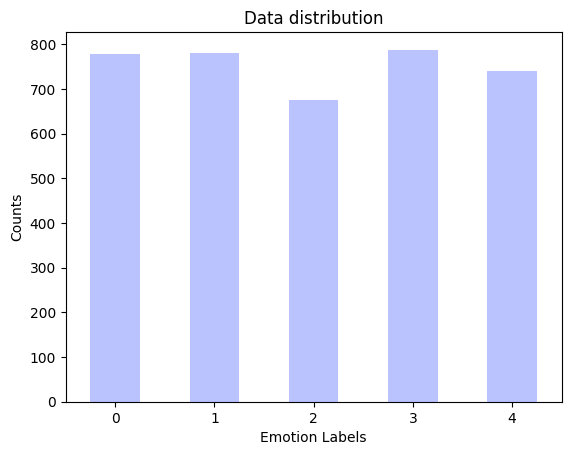

In [10]:
emotion_counts.plot(kind='bar', color='#bbc3ff')
plt.xticks(rotation=0)
plt.title("Data distribution")
plt.xlabel("Emotion Labels")
plt.ylabel("Counts")
plt.savefig("Data Distribution")

In [11]:
full_dataset["text"].apply(lambda x: len(x)).mean()

63.21068012752391

In [12]:
full_dataset["text"].apply(lambda x: len(x)).max()

149

In [13]:
import string

def remove_punctuation(input_text):
    nepali_punctuation = "।,;‘’!\"?(—)–#$%&'*+-./:<=>@[]^_`{|}~"
    translation_table = str.maketrans("", "", nepali_punctuation)
    cleaned_text = input_text.translate(translation_table)
    return cleaned_text

In [14]:
def preprocess_text(text):
    #Remove punctuation
    text_without_punctuation = remove_punctuation(text)
    return text_without_punctuation

In [15]:
full_dataset['text'] = full_dataset['text'].apply(preprocess_text)

In [16]:
full_dataset['text']

0                  ﻿ऒहोइ नेपालले पहिलो टुर्नामेन्ट जित्यो
1                   भारत बिरुद्ध को खेलमा नेपाल विजयी भयो
2                              मैले मेस्सिको अटोग्राफ पाए
3                 अर्जेन्टिनाले विश्वकप फूटबल २०२२ जित्यो
4               राष्ट्रिय खेलाडी सँग कुरा गर्ने अवसर पाए 
                              ...                        
3759    खुला पानीको अप्रत्याशित धाराहरूको सामना गर्दा ...
3760            आर्चरको प्रहारको सटीकता देखेर म छक्क परें
3761    खेल बिन्दु नजिक पुग्दा टेबलटेनिस खेलाडीको नसा ...
3762    डरले भलिबल खेलाडीको निर्णयलाई बादल बनायो किनभन...
3763    एस्पोर्टहरूमा डरले गेमरको हृदयलाई समात्यो किनभ...
Name: text, Length: 3764, dtype: object

In [17]:
full_dataset['tokens'] = full_dataset['text'].apply(tokenize_text)

Original Text: ﻿ऒहोइ नेपालले पहिलो टुर्नामेन्ट जित्यो
Actual Tokens: ['[CLS]', '[UNK]', 'नेपाल', '##ले', 'पहिलो', 'ट', '##ुर', '##्न', '##ाम', '##ेन', '##्ट', 'ज', '##ित', '##्यो', '[SEP]']
Original Text: भारत बिरुद्ध को खेलमा नेपाल विजयी भयो
Actual Tokens: ['[CLS]', 'भारत', 'ब', '##िर', '##ुद्ध', 'को', 'खेल', '##मा', 'नेपाल', 'विजय', '##ी', 'भयो', '[SEP]']
Original Text: मैले मेस्सिको अटोग्राफ पाए
Actual Tokens: ['[CLS]', 'म', '##ै', '##ले', 'मे', '##स', '##्स', '##िक', '##ो', 'अ', '##ट', '##ोग', '##्रा', '##फ', 'प', '##ा', '##ए', '[SEP]']
Original Text: अर्जेन्टिनाले विश्वकप फूटबल २०२२ जित्यो
Actual Tokens: ['[CLS]', 'अ', '##र', '##्ज', '##ेन', '##्ट', '##िन', '##ाल', '##े', 'विश्व', '##क', '##प', 'फ', '##ूट', '##बल', '२०', '##२', '##२', 'ज', '##ित', '##्यो', '[SEP]']
Original Text: राष्ट्रिय खेलाडी सँग कुरा गर्ने अवसर पाए 
Actual Tokens: ['[CLS]', 'राष्ट्रिय', 'खेल', '##ा', '##डी', 'स', '##ँ', '##ग', 'क', '##ुरा', 'गर्ने', 'अ', '##व', '##सर', 'प', '##ा', '##ए', '[SEP]']
Original Tex

In [18]:
full_dataset['embedded_text'] = full_dataset['tokens'].apply(embed_tokens)

In [19]:
X = pd.DataFrame(full_dataset['embedded_text'].tolist())
y = full_dataset['emotion']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [21]:
print("Size of X_train:", X_train.shape)
print("Size of X_test:", X_test.shape)

Size of X_train: (3199, 768)
Size of X_test: (565, 768)


In [22]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
2289,-0.089528,-0.010954,0.329146,0.268091,0.639425,0.370441,-0.502528,0.490437,-0.615435,0.830122,...,-0.365370,0.329301,-0.095152,-0.551237,0.278138,-0.749010,-0.159330,0.550265,0.085671,-0.027447
642,-0.016163,-0.186092,0.654122,0.391255,0.324571,0.358492,-0.069874,0.105518,0.079970,0.531081,...,-0.293690,0.354004,-0.154213,-0.513147,0.720814,-0.053448,-0.246413,0.530806,0.214265,-0.158112
1995,0.043301,-0.179264,0.474304,0.627811,0.538495,0.402199,-0.253888,0.294330,-0.055734,0.752353,...,-0.224408,0.461595,-0.222599,-0.360033,0.017764,-0.201718,-0.450865,0.141042,0.185975,-0.350048
1897,0.020900,-0.227206,0.615350,0.400091,0.293089,0.526788,-0.432709,0.466771,-0.228296,0.845658,...,-0.122544,0.194896,-0.633423,-0.127999,0.210042,-0.221361,-0.606025,0.578967,0.134416,-0.330030
1084,0.080309,-0.365403,0.202326,0.362581,0.604648,0.374760,-0.269180,0.727167,-0.736712,0.710975,...,-0.346746,0.024224,0.105758,-0.548143,0.224076,-0.412111,-0.362913,0.628173,-0.196218,-0.295541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,-0.087077,-0.293169,1.054448,0.500410,0.214893,0.049935,-0.084689,0.350585,-0.428592,0.599954,...,-0.259390,0.251910,-0.124245,-0.515043,0.423836,-0.164095,-0.289064,0.114862,0.055174,-0.102491
1294,0.285347,-0.030794,0.139421,0.193247,0.556379,0.437833,-0.332653,0.420330,-0.266249,0.501160,...,-0.226257,-0.011847,-0.016335,-0.740572,-0.005585,-0.333155,0.036333,0.470336,-0.102121,-0.103465
860,0.171821,-0.339536,0.739788,0.165333,0.056607,0.251443,-0.086811,0.620744,-0.149944,0.342026,...,-0.033469,0.132953,-0.254188,-0.467678,0.422657,-0.370659,-0.461584,0.283378,-0.050668,-0.180619
3507,0.057480,-0.242048,0.624547,0.559995,0.833276,0.300277,-0.415927,0.352461,-0.415413,0.526700,...,-0.172779,-0.033921,0.051346,-0.993200,-0.199874,-0.537045,-0.426749,0.531072,-0.392970,-0.392531


In [23]:
svm_model = SVC(probability= True)

In [24]:
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [36]:
grid = {

    'C':[0.01,0.1,1,10],

    'kernel' : ["linear","poly","rbf","sigmoid"],

    'degree' : [1,3,5,7],

    'gamma' : [0.01,1]

}

In [ ]:
# we can use GridSearchCV to find out the best parameters for the model
# Here I have just tried to find out what value for parameters does this provide, I haven't used these parameters. I sticked to default ones because RBF 
from sklearn.model_selection import GridSearchCV
svm_cv = GridSearchCV(svm_model, grid, cv = 5)
svm_cv.fit(X_train,y_train)

print("Best Parameters:",svm_cv.best_params_)
print("Train Score:",svm_cv.best_score_)
print("Test Score:",svm_cv.score(X_test,y_test))

In [25]:
# picke and save the m
import pickle
with open('svm_model.pkl', 'wb') as model_file:
        pickle.dump(svm_model, model_file)

In [26]:
y_pred_train= svm_model.predict(X_train)

In [27]:
print("Training Metrics:")
print(classification_report(y_train, y_pred_train)) 

Training Metrics:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       662
           1       0.75      0.68      0.71       660
           2       0.74      0.77      0.75       577
           3       0.76      0.79      0.78       663
           4       0.76      0.73      0.75       637

    accuracy                           0.75      3199
   macro avg       0.75      0.75      0.75      3199
weighted avg       0.75      0.75      0.74      3199



In [28]:
y_pred_test= svm_model.predict(X_test)

In [29]:
print("Test Metrics: ")
print(classification_report(y_test, y_pred_test)) 

Test Metrics: 
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       116
           1       0.61      0.63      0.62       121
           2       0.60      0.58      0.59        99
           3       0.66      0.69      0.67       125
           4       0.66      0.66      0.66       104

    accuracy                           0.64       565
   macro avg       0.64      0.64      0.64       565
weighted avg       0.64      0.64      0.64       565



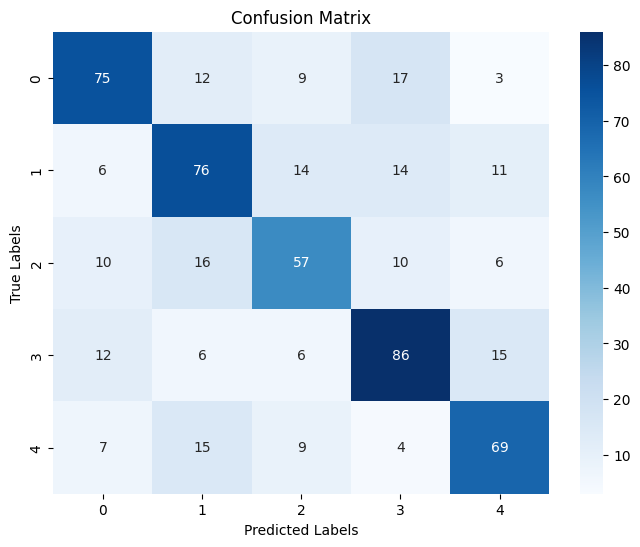

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
unique_classes = sorted(set(y_test) | set(y_pred_test))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("Confusion Matrix")
plt.show()

In [31]:
def predict_label(input_text, bert_tokenizer, bert_model, svm_model):
    preprocessed_text = preprocess_text(input_text)
    
    input_tokens = bert_tokenizer(preprocessed_text, return_tensors='pt',max_length=150, truncation=True, padding=True)
    with torch.no_grad():
        input_embedding = bert_model(**input_tokens)['last_hidden_state'].mean(dim=1).squeeze().numpy()
    input_data = pd.DataFrame([input_embedding])
    prediction = svm_model.predict(input_data)
    return prediction[0]

In [32]:
text1= "नेपालले खेल हार्याे |"
prediction=predict_label(text1, tokenizer, model, svm_model)
print("predicted emotion: ", prediction)

predicted emotion:  1


In [33]:
text2= " ओहो !"
prediction=predict_label(text2, tokenizer, model, svm_model)
print("predicted emotion: ", prediction)

predicted emotion:  0


In [34]:
text3= "भारत बिरुद्ध को खेलमा नेपाल विजयी भयो।"
prediction=predict_label(text3, tokenizer, model, svm_model)
print("predicted emotion: ", prediction)

predicted emotion:  0


In [35]:
text4= "नेपालको खेल देखेर धेरै रिस उठ्यो ।"
prediction=predict_label(text4, tokenizer, model, svm_model)
print("predicted emotion: ", prediction)

predicted emotion:  1
